## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---



## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp
!pip install datasets

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset('emotion')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']



In [ ]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]



    return tweets, labels


    #0: Sad ....... 5: Joy

In [ ]:
tweets, labels = get_tweets(train)

In [ ]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
# Anything that not present for 10000 word assignmend as <UNK>
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

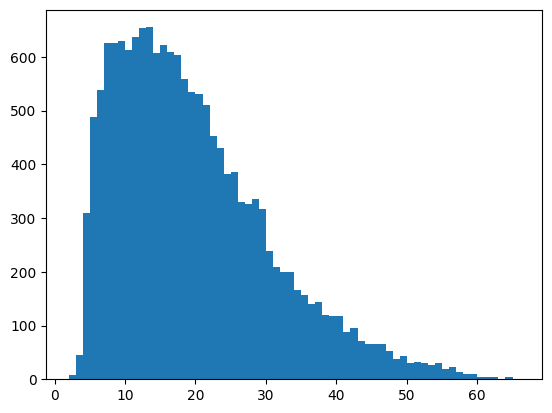

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths))) # histogram
plt.show()

In [ ]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post',maxlen=maxlen)
  # if length is less than 50 then untill makes length 50 adding padding 'post
  # also if length is greater than 50 then truncate it to length 50
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


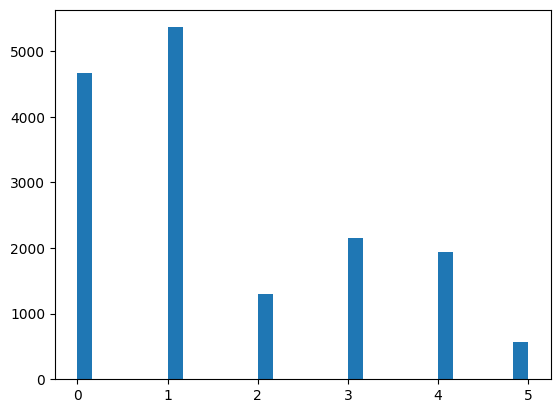

In [ ]:
plt.hist(labels, bins=30)
plt.show()

In [ ]:
#convert name of classes to corresponding numeric value

class_to_index = dict((c,i) for i,c in enumerate(classes)) # creating dictionary
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    # 10000 is input dimension 16 is output dimension
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    # LSTM can go left to right and vice versa
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy', # for multiclass
    optimizer = 'adam',
    metrics = ['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweets(val)
padded_val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)


In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 np.int64(0))

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(padded_val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
        #if the models does not see any impovement over 2 epoch the it will stop training
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.3724 - loss: 1.5502 - val_accuracy: 0.5905 - val_loss: 1.0638
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6640 - loss: 0.8649 - val_accuracy: 0.7695 - val_loss: 0.6429
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8332 - loss: 0.4674 - val_accuracy: 0.7990 - val_loss: 0.5661
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8678 - loss: 0.3684 - val_accuracy: 0.8005 - val_loss: 0.5534
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8994 - loss: 0.2598 - val_accuracy: 0.8565 - val_loss: 0.4417
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9446 - loss: 0.1614 - val_accuracy: 0.8790 - val_loss: 0.3673
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9621 - loss: 0.1161 - val_accuracy: 0.8920 - val_loss: 0.3677
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9704 - loss: 0.0894 - val

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

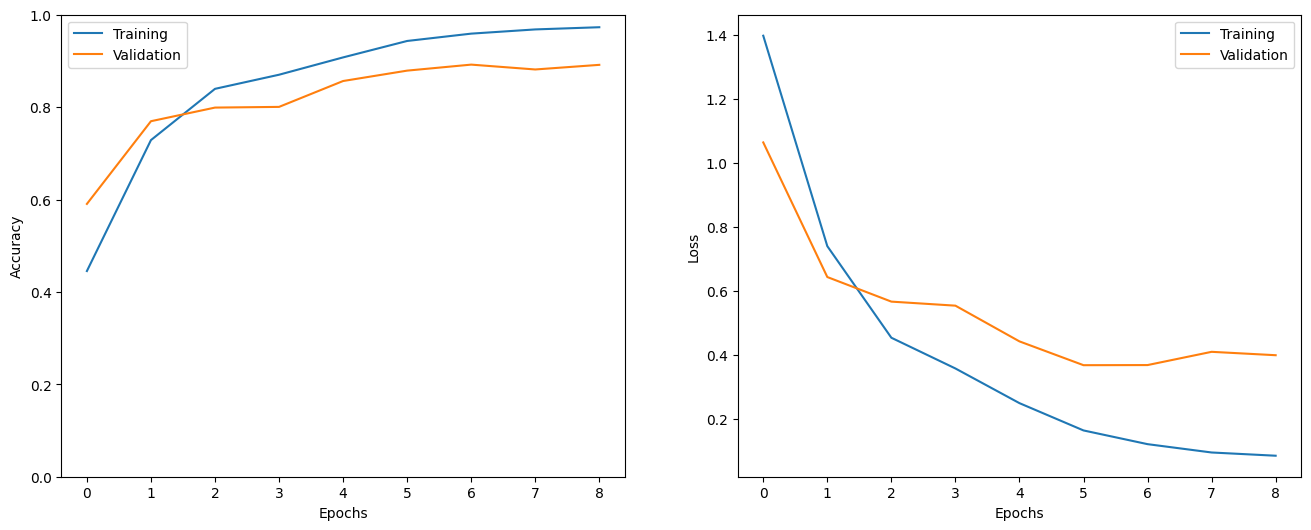

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweets(test)
padded_test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
h1 = model.evaluate(padded_test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8813 - loss: 0.4105


In [ ]:
i = random.randint(0, len(test_labels)-1)

print('sentence: ',test_tweets[i])
print('Emotion: ',index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(padded_test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')] # convert it into int using unit8

print('predicted emotion: ',pred_class)

sentence:  i am trying my hardest so i can get to a place where i can join you and finally feel like i have something worthwhile to say
Emotion:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted emotion:  1


In [ ]:
preds = model.predict(padded_test_seq)
preds

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([[9.99099731e-01, 5.77062543e-04, 1.21576495e-05, 2.65510113e-04,
        3.49698639e-05, 1.06783236e-05],
       [9.99178588e-01, 5.70988341e-04, 1.60023374e-05, 1.81718802e-04,
        3.81692007e-05, 1.45119393e-05],
       [9.99181807e-01, 5.65348833e-04, 2.15756045e-05, 1.59767340e-04,
        5.02092953e-05, 2.13798921e-05],
       ...,
       [3.04412504e-04, 9.98485863e-01, 7.31010572e-04, 1.60909942e-04,
        1.22078403e-04, 1.95823173e-04],
       [2.73834099e-04, 9.92520452e-01, 6.95860246e-03, 1.10895897e-04,
        6.33038289e-05, 7.29575258e-05],
       [1.42778212e-03, 1.10730967e-02, 8.15278734e-04, 3.89086636e-04,
        4.41533998e-02, 9.42141354e-01]], dtype=float32)

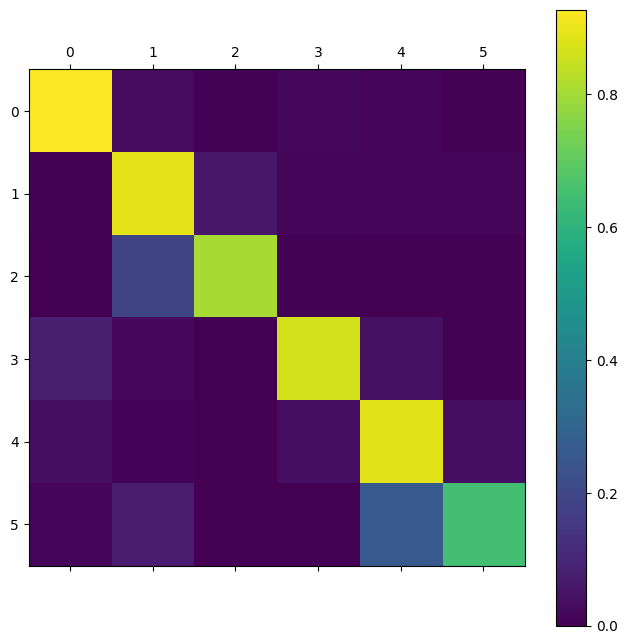

In [ ]:
from sklearn.metrics import confusion_matrix
show_confusion_matrix(test_labels, preds.argmax(axis=1), list(classes))
